In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 4.08 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [2]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/non-hierarchical/L_SHIE/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

subjects = sorted(df['participant'].unique())
# subjects = encoder_dict['participant'].inverse_transform(subjects)

positions = sorted(df['compound_position'].unique())
# positions = encoder_dict['compound_position'].inverse_transform(positions)
positions

charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
# charges = encoder_dict['compound_charge_params'].inverse_transform(charges)     # Then decode the charges, this maintains the order of the charges
muscles = model.response

In [4]:
stim_max = []
for s in subjects:
    for p in positions:
        for c in charges:
            for m in muscles:
                temp = df[(df['participant'] == s) 
                          & (df['compound_position'] == p) 
                          & (df['compound_charge_params'] == c) 
                          ]
                temp = temp.loc[:,[m, 'pulse_amplitude']]
                temp = temp.pulse_amplitude.max()
                stim_max.append(temp)

stim_max = ma.array(stim_max)
stim_max = stim_max.reshape(len(subjects), len(positions), len(charges), len(muscles))


In [5]:
ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)

4.0817093074014705

In [6]:
charges

[0, 1]

In [ ]:
def get_normalized_input_output():
    norm_y = []
    norm_x = []

    for subject_ind, subject in enumerate(subjects):
        # Fix the subject index and charge index
        curr_params = [
            params[:, subject_ind, :, :, :, None] for params in params
        ]

        # Take nanmean across posterior samples
        temp = np.nanmean(curr_params[0], axis=0)
        # Take nanmedian across compound positions and muscles
        median_threshold = np.nanmedian(temp)

        x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
        x_temp = x_temp[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp,
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_y = np.array(norm_y)
    norm_y = ma.masked_invalid(norm_y)
    return norm_x, norm_y


In [9]:
x, y = get_normalized_input_output()
y.shape

(8, 4000, 4, 2, 6, 500)

In [8]:
def plot_selectivity_comparison(charge_ind):
    x, y = get_normalized_input_output(charge_ind)
    num_masked = y.mask.any(axis=(2, -1)).sum()
    y_max = ma.max(y, axis=(2, -1), keepdims=True)
    
    num_masked = y.mask.sum()
    y = ma.where(y_max, y / y_max, 0.)
    
    p = ma.sum(y, axis=-2, keepdims=True)
    p = ma.where(p, y / p, 1 / y.shape[-2])
    
    plogp = ma.where(p, p * ma.log(p), 0.)

    entropy = 1 + (plogp.sum(axis=-2) / ma.log(y.shape[-2]))
    
    auc = np.trapz(y=entropy[...], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS), axis=-1)
    auc = auc.mean(axis=(1))
    
    mat = auc[:, :, None] - auc[:, None, :]
    
    pvalues = []
    for i in range(len(positions)):
        for i2 in range(len(positions)):
            if i==i2:
                pvalues.append(1)
                continue
            temp_p = stats.wilcoxon(mat[:, i,i2], axis=0).pvalue
            pvalues.append(temp_p)

    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(len(positions), len(positions))
    
    labels = encoder_dict['compound_position'].inverse_transform(positions)
    mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
    sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

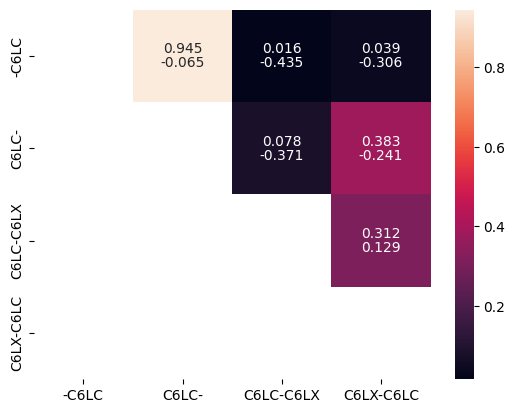

In [65]:
plot_selectivity_comparison(1)

In [9]:
encoder_dict['compound_position'].inverse_transform(positions)

array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [10]:
y.shape

(8, 4000, 4, 2, 6, 500)

In [11]:
y_max = ma.max(y, axis=(2, 3, -1), keepdims=True)
y_max = y_max[...,0,:,:]

In [12]:
y_mono = y[:, :, :, 0, :, :]

In [13]:
# num_masked = y.mask.any(axis=(2, -1)).sum()
# num_masked = y.mask.sum()

y_norm = ma.where(y_max, y_mono / y_max, 0.)

p = ma.sum(y_norm, axis=-2, keepdims=True)
p = ma.where(p, y_norm / p, 1 / y_norm.shape[-2])

plogp = ma.where(p, p * ma.log(p), 0.)

entropy = 1 + (plogp.sum(axis=-2) / ma.log(y_norm.shape[-2]))

auc = np.trapz(y=entropy[...], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS), axis=-1)
auc = auc.mean(axis=(1))

mat = auc[:, :, None] - auc[:, None, :]

In [14]:
mat.shape

(8, 4, 4)

In [15]:
pvalues = []
for i in range(len(positions)):
    for i2 in range(len(positions)):
        if i==i2:
            pvalues.append(1)
        else:
            pvalues.append(stats.wilcoxon(mat[:, i,i2], axis=0).pvalue)
        

In [16]:
labels = encoder_dict['compound_position'].inverse_transform(positions)

In [17]:
pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(positions), len(positions))

<Axes: >

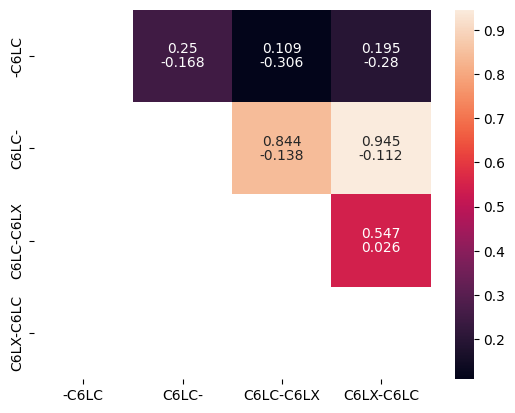

In [18]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [16]:
src = f"/home/andres/repos/rat-mapping-paper/notebooks/L_SHIE/cst_selectivity_means.pkl"

with open(src, "wb") as f:
    pickle.dump(auc, f)